## STOCK PRICE PREDICTION

We try to predict a stock price. In order to do that we will use the historical price of the stock itself, but we can also use other features like:
- correlated assets (competitor, global economy, FX, commodities, indices, other stocks prices)
- technical indicators (moving average, exponential moving average, momentum)
- foundamental analysis (performance report, news)

In this case we will focus on correlated assets as features, in particular stocks, currency and indices.

### Loading Python packages and data

In [1]:
import numpy as np
import pandas as pd
#pip install pandas_datareader
import pandas_datareader.data as web
import yfinance as yf

In [2]:
# ticker symbol: is a code that represents a particular stock
# stocks (Microsoft, Apple, Google)
stk_tickers = ['MSFT', 'AAPL', 'GOOGL']
# currency (USD/JPY, GBP/USD)
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
# indices (S&P 500, Dow Jones, VIX)
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [3]:
import datetime
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2024, 1, 1)
# Take data from Yahoo Finance
# stk_data = web.DataReader(stk_tickers, 'yahoo') datareader is broken with yahoo
stk_data = yf.download(stk_tickers, start=start, end=end)#period='5y')
# Take data from Federal Reserve Economic Data
ccy_data = web.DataReader(ccy_tickers, 'fred', start=start, end=end).iloc[1:,:]
idx_data = web.DataReader(idx_tickers, 'fred', start=start, end=end).iloc[1:,:]

[*********************100%%**********************]  3 of 3 completed


The predicted variable is the weekly return of Microsoft (MSFT). The number of trading days in a week is assumed to be five, and we compute the return using five trading days. For independent variables we use the correlated assets(with lagged five-day return) and the historical return of MSFT at different frequencies (lagged 5-day, 15-day, 30-day and 60-day return). We will use logarithmic returns.

Logarithmic returns are important in finance because they provide a more accurate measure of the percentage change in the value of an asset over a period of time. This is particularly important when analyzing financial data because the compounding effect of returns over time can have a significant impact on the value of an asset.
Logarithmic returns are also useful because they are additive. That is, the logarithmic return of a portfolio composed of multiple assets is simply the sum of the logarithmic returns of each individual asset. This makes it easy to calculate the overall performance of a portfolio over a period of time.
Another advantage of using logarithmic returns is that they are normally distributed, which makes them easier to work with mathematically. This is because the natural logarithm of a number is a continuous and smooth function, which means that the resulting distribution of logarithmic returns is also continuous and smooth.




In [5]:
# It will "group" 5 days of data
return_period = 5
# y is the target variable
# take the log of the shifted difference
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

In [6]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'AAPL'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

In [7]:
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) \
      for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [8]:
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

### Data Visualization
We visualize the correlation between dependent and  independent variables, plus the correlation between the independent variables themself. It's useful to know because some machine learning algorithms like linear and logistic regression can have poor performance if there are highly correlated input variables in the data.

<Axes: title={'center': 'Correlation Matrix'}>

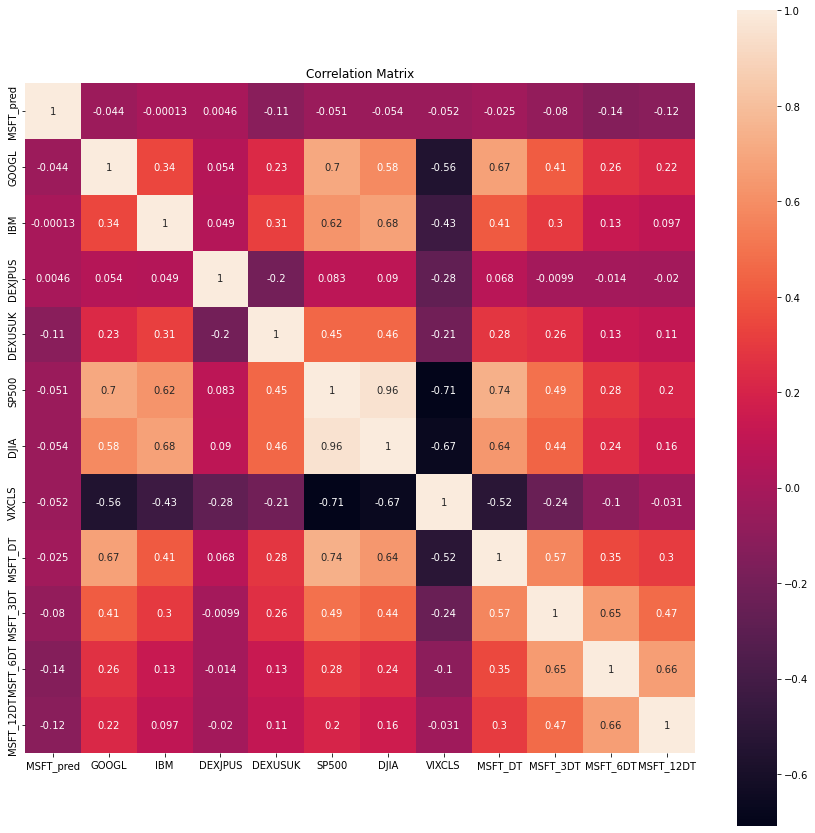

In [9]:
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
# pip install seaborn
import seaborn as sns

correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True)

<Figure size 1080x1080 with 0 Axes>

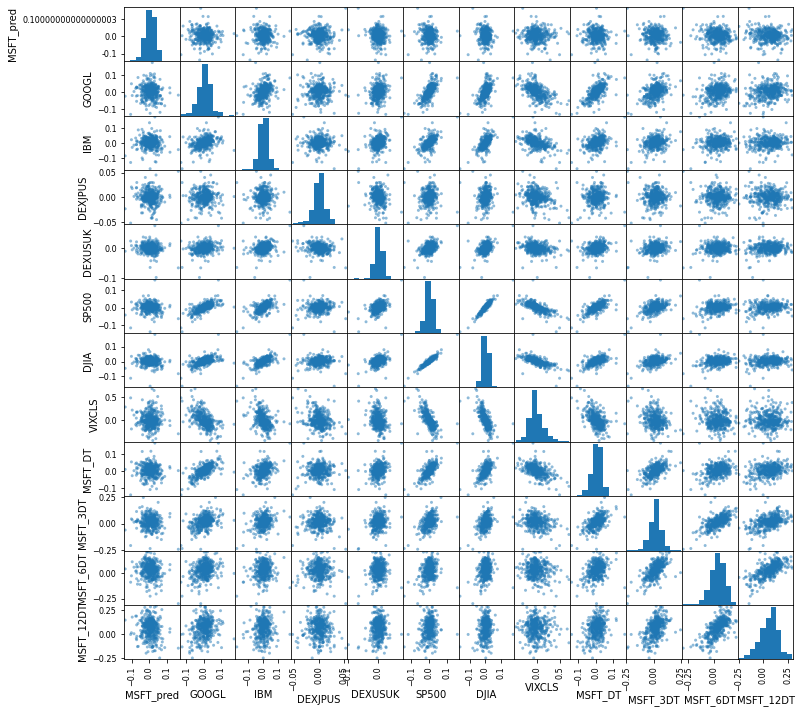

In [10]:
from pandas.plotting import scatter_matrix
# We can notice a linear relationship between some variables (e.g. S&P500 and Google)
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

#### Time Series analysis

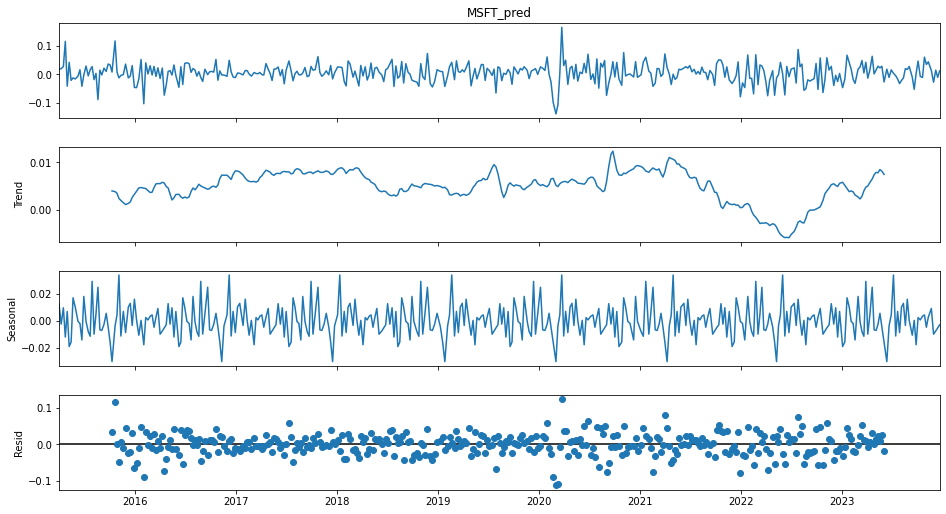

In [11]:
# pip install statsmodels
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(Y,period=52) # 52 beacause there are 52 weeks in a year
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

### Data preparation
This step typically involves data processing, data cleaning, looking at feature importance, and performing feature reduction, but in this case the dataset is ok like that.

### Evaluate the model

In [12]:
# Train-Test set split
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

# We will use cross validation (10-fold)
num_folds = 10
# MSE as error function
scoring = 'neg_mean_squared_error'

### Models and algorithm to use

All the algorithms use default tuning parameters. We will calculate the mean and standard deviation of the evaluation metric for each algorithm and collect the results for model comparison

In [13]:
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

models = []
# Regression and tree regression
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# Neural network algorithm
models.append(('MLP', MLPRegressor())) 
# Ensemble models: boosting and bagging
# Boosting methods
models.append(('ABR', AdaBoostRegressor())) 
models.append(('GBR', GradientBoostingRegressor())) 
# Bagging methods
models.append(('RFR', RandomForestRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))

We will calculate the mean and standard deviation of the evaluation metric for each algorithm and collect the results for model comparison

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

seed = 21
names = []
kfold_results = [] 
test_results = [] 
train_results = []

for name, model in models:
    names.append(name)
    ## k-fold analysis:
    kfold = KFold(n_splits=num_folds)
    #converted mean squared error to positive. The lower the better 
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train) 
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test) 
    test_results.append(test_result)

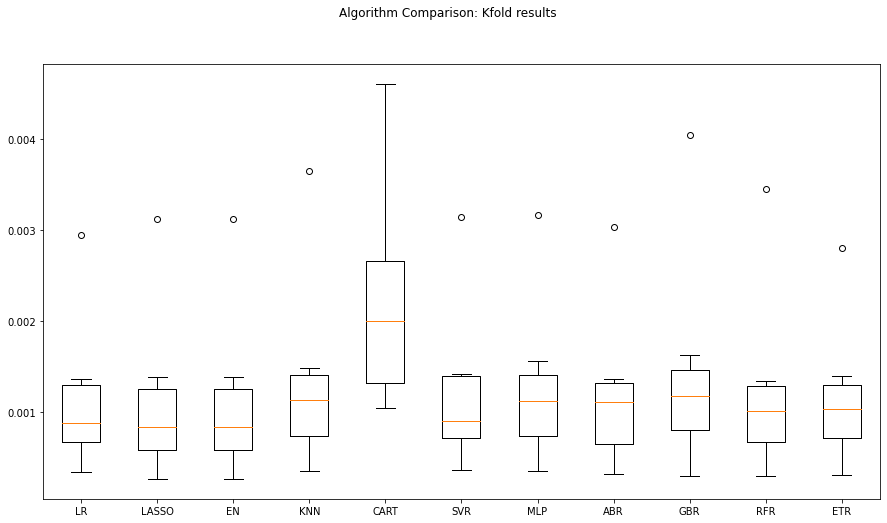

In [15]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

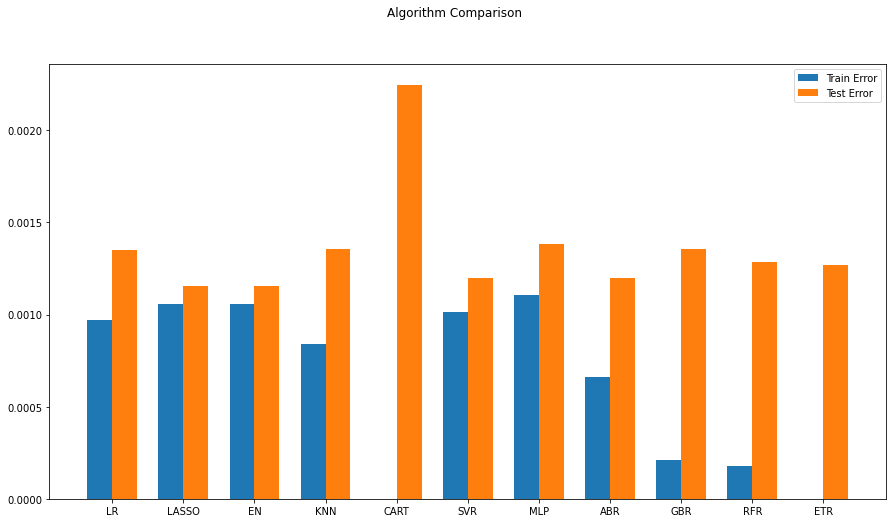

In [16]:
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Now we will use some time series and deep learning models, but we can't use k-fold with them beacause they are time series models and not regression-based models.
#### ARIMAX 
For the time series–based models we do not need the lagged variables of MSFT as the independent variables. We use all other variables as the exogenous variables in these models.

In [17]:
from statsmodels.tsa.arima.model import ARIMA 

X_train_ARIMA=X_train.loc[:, ['GOOGL', 'AAPL', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'AAPL', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

# ARIMAX model (ARIMS with exogenous variable)
# fit
modelARIMA=ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()
# train
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
# predict
predicted = model_fit.predict(start=tr_len-1 ,end=to_len-1, exog=X_test_ARIMA)[1:]
# error
error_Test_ARIMA = mean_squared_error(Y_test, predicted)
print(error_Test_ARIMA)


/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


0.0011860563300436751


/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### LSTM
Logic behind the LSTM is that data is taken from the previous day and we try to predict the next day. Then we move the one-day window with one day and again predict the next day. We iterate like this over the whole dataset. The code below will create a dataset in which X is the set of independent variables at a given time (t) and Y is the target variable at the next time (t + 1):

In [18]:
from keras.models import Sequential 
from keras.layers import Dense 
#from keras.optimizers import SGD 
# FOR MAC M1
from keras.optimizers.legacy import SGD
from keras.layers import LSTM
# LSTM dataset
seq_len = 2 #Length of the seq for the LSTM
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test) 
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1])) 
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]
    
# LSTM model
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1],\
    X_train_LSTM.shape[2])))
    #More cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum) 
    model.compile(loss='mse', optimizer='adam') 
    return model

LSTMModel = create_LSTMmodel(learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, 
                              validation_data = (X_test_LSTM, Y_test_LSTM),
                              epochs=330, batch_size=72, verbose=0, shuffle=False)

/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


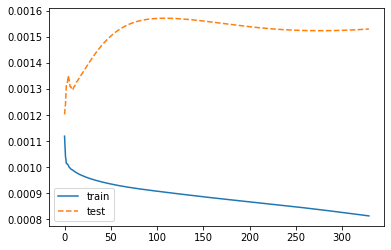

3/3 [==============================] - 0s 9ms/step


In [19]:
# LSTM error
pyplot.plot(LSTMModel_fit.history['loss'], label='train', )
pyplot.plot(LSTMModel_fit.history['val_loss'], '--',label='test',)
pyplot.legend()
pyplot.show()

error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [20]:
# We compare the results with the previous models
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
names.append("ARIMA")
names.append("LSTM")

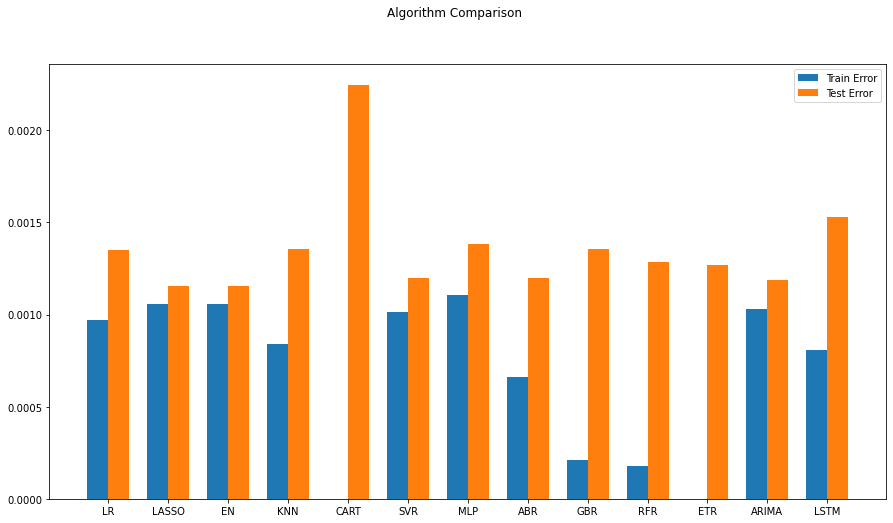

In [21]:
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We find the time series–based ARIMA model comparable to the linear supervised regression modelsThe LSTM model performs decently; however, the ARIMA model outperforms the LSTM model in the test set. Hence, we select the ARIMA model for model tuning.


### Model tuning and grid search

In [22]:
import warnings

# ARIMA(p, d, q) -> we perform a grid search of these parameters
def evaluate_arima_model(arima_order):
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order) 
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values: 
            for q in q_values:
                order = (p,d,q) 
                try:
                    mse = evaluate_arima_model(order) 
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except: 
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

In [23]:
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0010294
ARIMA(0, 0, 1) MSE=0.0010281
ARIMA(0, 1, 0) MSE=0.0017188
ARIMA(0, 1, 1) MSE=0.0010557
ARIMA(1, 0, 0) MSE=0.0010279
ARIMA(1, 0, 1) MSE=0.0010280
ARIMA(1, 1, 0) MSE=0.0014733
ARIMA(1, 1, 1) MSE=0.0010732
ARIMA(2, 0, 0) MSE=0.0010270
ARIMA(2, 0, 1) MSE=0.0010267
ARIMA(2, 1, 0) MSE=0.0014061
ARIMA(2, 1, 1) MSE=0.0010846
Best ARIMA(2, 0, 1) MSE=0.0010267


We see that the ARIMA model with the order (2,0,1) is the best performer out of all the combinations tested in the grid search, although there isn’t a significant difference in the mean squared error (MSE) with other combinations.

### Finalize the model

In [24]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,\
end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0011860563300436751


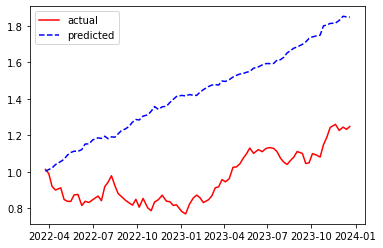

In [25]:
# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual',)
# plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (16,8)
pyplot.show()

The trend has been captured perfectly by the model. A point to note is that the purpose of the model is to compute the next day’s return given the data observed up to the present day, and not to predict the stock price several days in the future given the current data. Hence, a deviation from the actual data is expected as we move away from the beginning of the test set.